In [1]:
import math
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas_datareader as pdr
from datetime import datetime, timedelta

In [2]:
#Get the stock
ticker = 'CVS'
stock ="CVS"
# Time step n days, here we will use n  days historical data to predict next day closing
ts_points = 120
# train_data[0:60,0]  

today = datetime.today()
# start_date ='2016-01-01'
start_date = (today - timedelta(days=5*365) ).strftime('%Y-%m-%d')

end_date   = today.strftime('%Y-%m-%d')
stock_df = pdr.DataReader(ticker, data_source="yahoo", start=start_date, end=end_date)

In [3]:
# Date is an index but to be sure , let's sort
stock_df = stock_df.sort_index(ascending=True)
stock_df

High        Low       Open      Close      Volume  Adj Close
Date                                                                         
2016-10-24  88.580002  87.639999  87.639999  88.000000   4541900.0  76.222649
2016-10-25  88.209999  87.290001  87.800003  87.410004   3803700.0  75.711609
2016-10-26  87.650002  87.010002  87.480003  87.570000   3313500.0  75.850204
2016-10-27  87.930000  86.910004  87.720001  87.190002   3570600.0  75.521049
2016-10-28  85.489998  82.550003  85.349998  83.360001  17206700.0  72.203621
...               ...        ...        ...        ...         ...        ...
2021-10-18  85.750000  84.120003  85.750000  84.480003   4822100.0  83.991959
2021-10-19  85.309998  84.620003  84.970001  84.889999   3833000.0  84.399590
2021-10-20  86.830002  85.000000  85.099998  86.550003   5023300.0  86.050003
2021-10-21  86.889999  85.709999  85.839996  86.860001   5347200.0  86.860001
2021-10-22  87.589996  86.239998  86.480003  87.519997   5035400.0  87.519997

[1259 rows x 6 columns]

In [4]:
# check for nulls
stock_df.isna().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [5]:
# Get shape
stock_df.shape

(1259, 6)

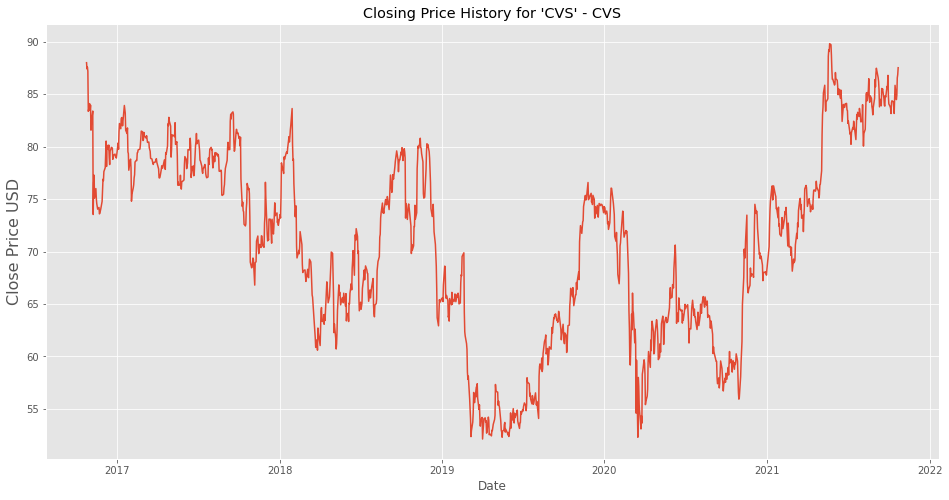

In [6]:
# Visualize closing price history
plt.figure(figsize=(16,8))
plt.title (f"Closing Price History for '{stock}' - {ticker}")
plt.plot(stock_df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD', fontsize=16)
plt.show()

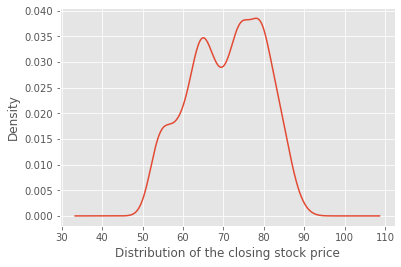

In [7]:
stock_df['Close'].plot.density()
plt.xlabel('Distribution of the closing stock price')
plt.show()

In [8]:
# DF with only close
TSdata_df = stock_df.filter(['Close'])
TSdata_arr = TSdata_df.values # this creates an array of Close Price
TSdata_arr

array([[88.        ],
       [87.41000366],
       [87.56999969],
       ...,
       [86.55000305],
       [86.86000061],
       [87.51999664]])

In [9]:
# Scale the Data
scaler = MinMaxScaler(feature_range =(0,1))
scaled_data = scaler.fit_transform(TSdata_arr)
# scaled_data

In [10]:
training_data_len = math.ceil(len(TSdata_arr) * 0.75)
training_data_len

945

In [11]:
# Created scaled training dataset
train_data = scaled_data[0:training_data_len]
train_data.shape

(945, 1)

In [12]:
# Split
X_train = []
y_train = []

for i in range(ts_points, len(train_data)):
    X_train.append(train_data[i-ts_points:i,0])
    y_train.append(train_data[i,0])
    # if i <= ts_points+3:
    #     print(X_train)
    #     print(y_train)
    #     print()


In [13]:
# convert X_train and y_train to numpy arrays for LSTM
X_train, y_train = np.array(X_train), np.array(y_train)

In [14]:
print (X_train.shape)
print (y_train.shape)

(825, 120)
(825,)


In [15]:
# LSTM network expects a 3D input (No_of_Samples, number of time steps, and number of features) no_of_features = 1 (Close)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(825, 120, 1)

In [16]:
training_data_len - ts_points

825

In [202]:
# hidden_nodes = int(2/3 * (X_train.shape[1] * 1))
# print(f"The number of hidden nodes is {hidden_nodes}.")

In [17]:
# LSTM MOdel
model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
# model.add(tf.keras.layers.LSTM(50, return_sequences=False))
# model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.Dense(25))
# model.add(tf.keras.layers.Dense(1))
# model.summary()


In [18]:

# BEST FOR TESLA#
model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(tf.keras.layers.LSTM(50, return_sequences=False))
# model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(25))
model.add(tf.keras.layers.Dense(1))
model.summary()

#model.fit(X_train, y_train, batch_size=64, epochs=50

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(optimizer='adam', loss='mean_squared_error')
# model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [21]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size=64

os.makedirs("chk_points/", exist_ok=True)
chkpoint_path="chk_points/weights.{epoch}.hdf5"

# Create chk points
chkpt_callback = ModelCheckpoint(filepath=chkpoint_path,
                              verbose=1,
                              save_weights_only=True,
                              save_freq="epoch",
                              period=5)

# chkpoint_path = "chk_points/cp-{epoch:04d}.ckpt"
# chkpt_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=chkpoint_path, 
#     verbose=1, 
#     save_weights_only=True,
#     save_freq=5*batch_size)                    

# model.save_weights(chkpoint_path.format(epoch=0))    


In [207]:
# training_data_len
# scaled_data

In [22]:
# model.fit(X_train, y_train, batch_size=batch_size, epochs=50, validation_split=0.43, callbacks=[chkpt_callback])
model.fit(X_train, y_train, batch_size=64, epochs=50)

Epoch 1/50
13/13 [==============================] - 4s 114ms/step - loss: 0.0559
Epoch 2/50
13/13 [==============================] - 1s 115ms/step - loss: 0.0125
Epoch 3/50
13/13 [==============================] - 1s 109ms/step - loss: 0.0085
Epoch 4/50
13/13 [==============================] - 1s 109ms/step - loss: 0.0069
Epoch 5/50
13/13 [==============================] - 1s 102ms/step - loss: 0.0057
Epoch 6/50
13/13 [==============================] - 1s 101ms/step - loss: 0.0056
Epoch 7/50
13/13 [==============================] - 1s 105ms/step - loss: 0.0053
Epoch 8/50
13/13 [==============================] - 1s 103ms/step - loss: 0.0050
Epoch 9/50
13/13 [==============================] - 1s 104ms/step - loss: 0.0049
Epoch 10/50
13/13 [==============================] - 1s 114ms/step - loss: 0.0047
Epoch 11/50
13/13 [==============================] - 2s 126ms/step - loss: 0.0045
Epoch 12/50
13/13 [==============================] - 2s 120ms/step - loss: 0.0044
Epoch 13/50
13/13 [======

In [23]:
model.save('Saved_Models/Model_'+ticker+'.h5')

In [24]:
# test_data = scaled_data[training_data_len:]

# Bring in the last 'ts_points' (60 values) from training set so when X_test is used to predict , predictions have same shape as Y_test
# The for loop starts with 'ts_points' thatbmeans the resultant array will have 60 less rows
test_data = scaled_data[training_data_len-ts_points:]
# test_data[0:60,0]


In [25]:
X_test = []
y_test = TSdata_arr[training_data_len:]
for i in range(ts_points, len(test_data)):
    X_test.append(test_data[i-ts_points:i,0])


In [26]:
# convert the data to a numpy array to use it in LSTM MODEL
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],  X_test.shape[1], 1))

In [27]:
from sklearn.metrics import mean_squared_error

In [28]:
# Models predicted price for X_train
predictions_tr = model.predict(X_train)
predictions_tr = scaler.inverse_transform(predictions_tr)

y_train_tr =  scaler.inverse_transform(y_train.reshape(-1,1))
rmse_tr = math.sqrt(mean_squared_error(y_train_tr, predictions_tr))
rmse_tr

1.4566285371745835

In [29]:
# Models predicted price for X_test
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [30]:
y_test.shape, predictions.shape

((314, 1), (314, 1))

In [31]:
# RMSE to check accuracy

rmse = math.sqrt(mean_squared_error(y_test, predictions))
rmse

1.315212435069533

In [32]:
# Plot
train = TSdata_df[:training_data_len]
actual = TSdata_df[training_data_len:]
actual['Predictions'] = predictions
actual

<ipython-input-32-bb86776ae978>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual['Predictions'] = predictions


Close  Predictions
Date                              
2020-07-28  63.270000    63.009464
2020-07-29  64.220001    63.016605
2020-07-30  64.000000    63.586758
2020-07-31  62.939999    64.027191
2020-08-03  63.860001    63.811314
...               ...          ...
2021-10-18  84.480003    84.734268
2021-10-19  84.889999    84.560593
2021-10-20  86.550003    84.308594
2021-10-21  86.860001    85.280273
2021-10-22  87.519997    86.146271

[314 rows x 2 columns]

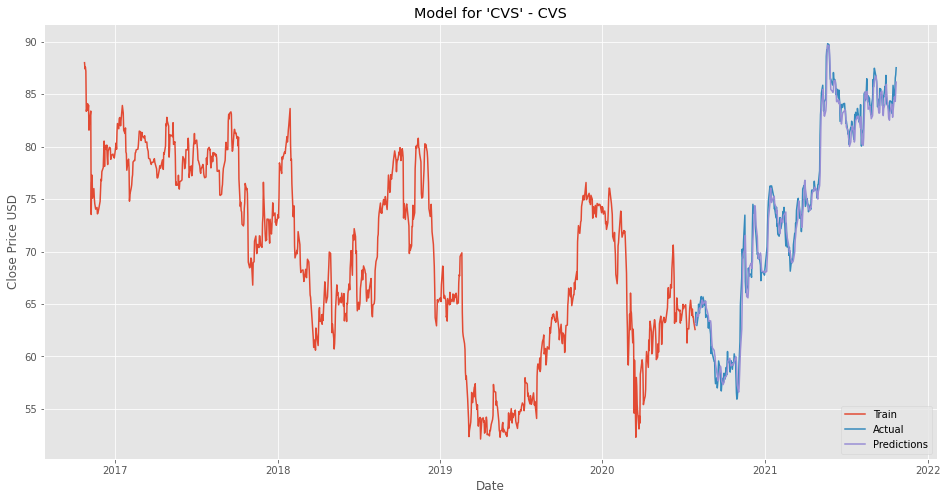

In [33]:
plt.figure(figsize=(16,8))
plt.title(f"Model for '{stock}' - {ticker}")
plt.xlabel("Date")
plt.ylabel("Close Price USD")
plt.plot(train['Close'])
plt.plot(actual[['Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.show()

# TEST

In [34]:
# for predictions add 100 extra days to make sure it has more than ts_points to make up for missing days (weekends and holidays)

fetch_days = ts_points + 100    

sd =  today - timedelta(days=fetch_days)
sd = sd.strftime('%Y-%m-%d')

ed = today.strftime('%Y-%m-%d')
ed

next_day = (today + timedelta(days=1) ).strftime('%Y-%m-%d')
# next_day

In [35]:
# get the quote
quote = pdr.DataReader(ticker, data_source="yahoo", start=sd, end=ed)
new_df = quote.filter(['Close'])
last_n_days = ts_points
last_n_days_arr = new_df[-last_n_days:].values 

In [36]:
last_n_days_scaled = scaler.transform(last_n_days_arr)
X_test = []
X_test.append(last_n_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0], X_test.shape[1],1))


In [37]:
##########################loading saved model ###############################
new_model = tf.keras.models.load_model('Saved_Models/Model_'+ticker+'.h5')

# Check its architecture
new_model.summary()
nmpred_price = new_model.predict(X_test)
nmpred_price = scaler.inverse_transform(nmpred_price)
nmpred_price = nmpred_price[0][0]
print(f"Predicted Closing price for '{stock}' on {next_day} is {nmpred_price:.4f}")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________
Predicted Closing price for 'CVS' on 2021-10-24 is 86.8428


In [38]:
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
pred_price = pred_price[0][0]
print(f"Predicted Closing price for '{stock}' on {next_day} is {pred_price:.4f}")

Predicted Closing price for 'CVS' on 2021-10-24 is 86.8428


In [39]:
# verify
d1 = today - timedelta(days=5)
d1 = d1.strftime('%Y-%m-%d')

quote2 = pdr.DataReader(ticker, data_source="yahoo", start=d1)
quote2

High        Low       Open      Close     Volume  Adj Close
Date                                                                        
2021-10-18  85.750000  84.120003  85.750000  84.480003  4822100.0  83.991959
2021-10-19  85.309998  84.620003  84.970001  84.889999  3833000.0  84.399590
2021-10-20  86.830002  85.000000  85.099998  86.550003  5023300.0  86.050003
2021-10-21  86.889999  85.709999  85.839996  86.860001  5347200.0  86.860001
2021-10-22  87.589996  86.239998  86.480003  87.519997  5035400.0  87.519997